### Introduction

In the field of Natural Language Processing (NLP), text classification is a crucial task with wide applications. Specifically, the automated classification of news articles plays a significant role in efficiently organizing large amounts of information and delivering relevant content to users. This project focuses on the BBC News Classification task as part of a Kaggle competition, where news articles are categorized into distinct groups such as "Business," "Sports," "Entertainment," and more.

#### Objective
The goal of this project is to build a model capable of categorizing BBC news articles into predefined categories. The main approach employed in this project is matrix factorization for unsupervised learning to predict the categories of the news articles. Additionally, a comparison with supervised learning methods will be performed to evaluate the performance and efficiency of both approaches.


### Exploratory Data Analysis (EDA)

#### 1. Load and Inspect the Data

I begin by loading the training and test datasets and inspecting their basic structure. This helps me understand the types of data I am dealing with and check for any missing or inconsistent values.

In [2]:
import pandas as pd

# Load the training and test datasets
train_data = pd.read_csv('learn-ai-bbc/BBC News Train.csv')
test_data = pd.read_csv('learn-ai-bbc/BBC News Test.csv')

# Display the first few rows of the training data
print(train_data.head())
print(train_data.info())
print(test_data.info())

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  7

From this inspection, I can see that the dataset contains `ArticleId`, `Text`, and `Category` columns. The `Category` column represents the target variable, which I will attempt to predict.

#### 2. Check for Missing Values

Next, I check for missing data to ensure that there are no gaps in the dataset. Any missing data will need to be handled either by imputation or removal.

In [3]:
# Check for missing values in the datasets
print(train_data.isnull().sum())
print(test_data.isnull().sum())

ArticleId    0
Text         0
Category     0
dtype: int64
ArticleId    0
Text         0
dtype: int64


Luckily, there are no missing values in either dataset, so I can proceed to the next step.

### 3. Visualize the Data Distribution

To better understand the target variable (`Category`), I visualize the distribution of categories in the training dataset.


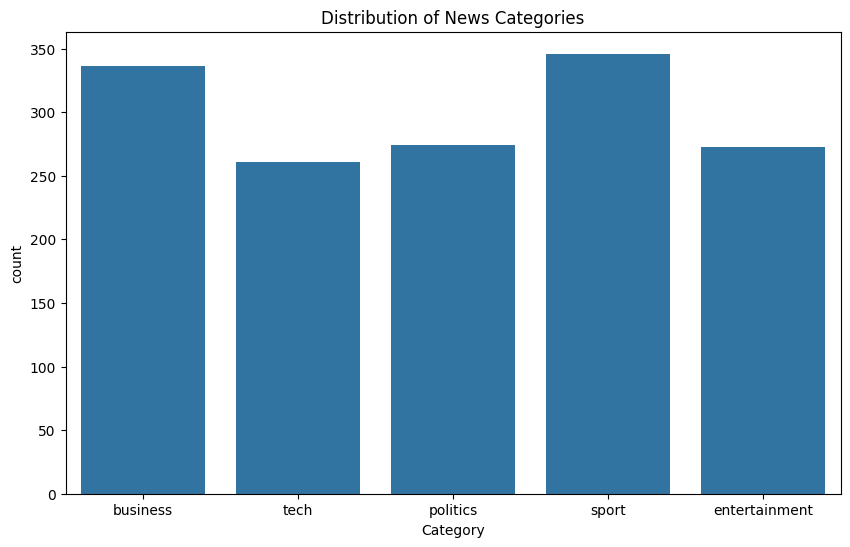

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target labels
plt.figure(figsize=(10,6))
sns.countplot(x='Category', data=train_data)
plt.title('Distribution of News Categories')
plt.show()

From the plot, I observe that the categories are fairly balanced, though some categories may have slightly more articles than others. This is important because imbalanced classes could impact model performance.


#### 4. Text Preprocessing

Before applying any machine learning models, I need to clean the text data. This involves several steps:
- Lowercasing all text
- Removing punctuation and numbers
- Removing stopwords (common but unimportant words such as "the", "is")
- Lemmatizing words (converting words to their base form)

In [14]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stopwords and lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    
    return text

# Apply preprocessing to the training data
train_data['cleaned_text'] = train_data['Text'].apply(preprocess_text)

Display Original and Cleaned Text

In [18]:
# Compare the original text and the cleaned text
for i in range(3):  # Display the first 3 articles
    print("Original Text:")
    print(train_data['Text'].iloc[i])
    print("\nCleaned Text:")
    print(train_data['cleaned_text'].iloc[i])
    print("\n" + "="*80 + "\n")

Original Text:
worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by wo

Display Word Frequency

Most common words:
[('said', 4838), ('mr', 2006), ('year', 1853), ('would', 1711), ('also', 1426), ('new', 1334), ('people', 1323), ('u', 1227), ('one', 1190), ('could', 1032)]


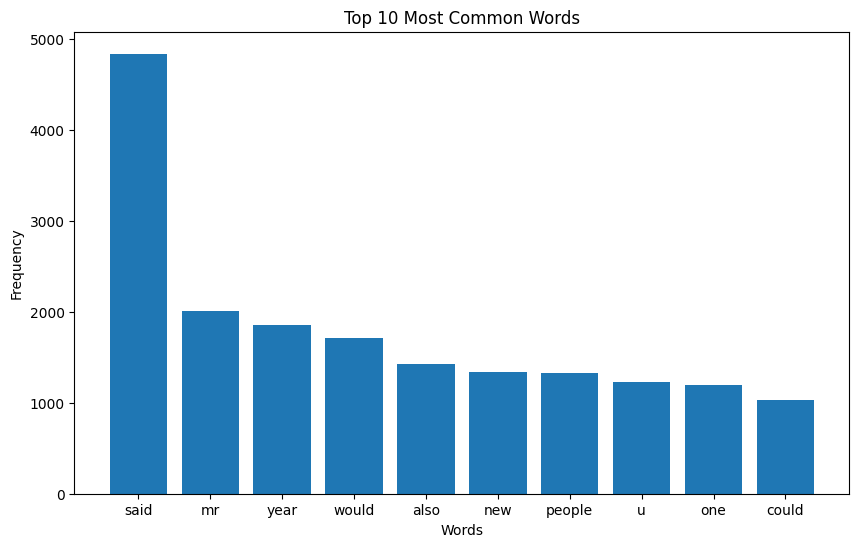

In [19]:
from collections import Counter

# Combine all cleaned text and count word occurrences
all_words = ' '.join(train_data['cleaned_text']).split()
word_freq = Counter(all_words)

# Display the 10 most common words
print("Most common words:")
print(word_freq.most_common(10))

import matplotlib.pyplot as plt

# Get the top 10 most common words and their frequencies
common_words = word_freq.most_common(10)
words, counts = zip(*common_words)

# Plot a bar chart to show word frequency
plt.figure(figsize=(10,6))
plt.bar(words, counts)
plt.title('Top 10 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


### 5. Feature Extraction

After preprocessing the text data, I need to convert it into a format that machine learning models can process. In this case, I will use **TF-IDF** (Term Frequency-Inverse Document Frequency) to transform the text into numerical vectors.

#### What is TF-IDF?

TF-IDF is a common feature extraction technique in Natural Language Processing (NLP) that quantifies the importance of a word in a document relative to a collection of documents (the corpus). It assigns higher scores to words that are frequent in a specific document but not common across all documents, helping to prioritize unique and meaningful words.

#### Process

The cleaned text is transformed into TF-IDF vectors with the following steps:
- **Term Frequency (TF)**: Measures how often a word appears in a document.
- **Inverse Document Frequency (IDF)**: Reduces the importance of common words across all documents.
- **Resulting Matrix**: Each document is represented as a vector of TF-IDF scores for the most important words.

The `TfidfVectorizer` from `scikit-learn` is used to accomplish this, with a limit of 5000 features (i.e., the top 5000 most important words).


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(train_data['cleaned_text'])

# Check the shape of the resulting TF-IDF matrix
print(X_train_tfidf.shape)

(1490, 5000)


### 5.1. TF-IDF Results

After applying TF-IDF, the resulting matrix has a shape of `(1490, 5000)`, indicating that the training dataset consists of 1490 articles, each represented by 5000 features. These features correspond to the most important words, as determined by their term frequency and inverse document frequency scores.

#### Interpretation of the Results:
- **Number of Documents (1490)**: This reflects the number of news articles in the training dataset.
- **Number of Features (5000)**: Each article is now represented as a vector of 5000 features (words), where each feature's value is a TF-IDF score that measures its importance relative to other articles.
- **Feature Selection**: By limiting the number of features to the top 5000 words, I ensure that the model focuses on the most relevant terms, reducing noise and improving computational efficiency.

At this point, the text data has been successfully transformed into a numerical format that can be used for machine learning model building. The next step is to proceed with model training and evaluation.

### 6. Model Building and Training

I will now apply machine learning algorithms to the TF-IDF matrix to classify the news articles. Two types of models will be compared:
1. **Matrix Factorization (Unsupervised Learning)**: This method will help identify hidden patterns in the data and predict categories based on the discovered latent factors.
2. **Supervised Learning**: I will also build a supervised learning model, such as Logistic Regression or Random Forest, using the labeled data, and compare its performance to the unsupervised approach.

The performance of both models will be evaluated based on accuracy, precision, and other metrics, with particular attention to overfitting and generalization.


### 6. Model Building and Training

#### 6.1 Matrix Factorization (Unsupervised Learning)

Matrix factorization is an unsupervised learning technique used to discover latent patterns in data, which can help predict categories based on hidden structures. For this, I will use **Non-negative Matrix Factorization (NMF)** to predict the categories of the news articles.


In [21]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

# Initialize NMF model
nmf_model = NMF(n_components=6, random_state=42)  # Assume we have 6 categories

# Fit the NMF model to the TF-IDF data
W = nmf_model.fit_transform(X_train_tfidf)
H = nmf_model.components_

# Normalize the matrix to interpret the results better
W_norm = normalize(W, norm='l1', axis=1)

# Predict categories by finding the highest weight for each article
predicted_categories_nmf = W_norm.argmax(axis=1)

# Display the predicted categories
print(predicted_categories_nmf[:10])  # Show the first 10 predictions


[4 4 4 0 4 1 3 2 4 2]


- Each number corresponds to a predicted category, where the model has assigned one of six possible categories (labeled as 0, 1, 2, 3, 4, 5) to each article.
- The matrix `W`, which was normalized to better interpret the results, provides the weight for each article across all possible categories. The predicted category for each article is the one with the highest weight in `W`.


#### 6.2 Supervised Learning

Next, I will use **Logistic Regression**, a supervised learning model, to classify news articles based on the TF-IDF matrix.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, train_data['Category'], test_size=0.2, random_state=42)

# Initialize and train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9765100671140939
               precision    recall  f1-score   support

     business       0.97      0.99      0.98        75
entertainment       0.98      1.00      0.99        46
     politics       0.96      0.95      0.95        56
        sport       0.97      1.00      0.98        63
         tech       1.00      0.95      0.97        58

     accuracy                           0.98       298
    macro avg       0.98      0.98      0.98       298
 weighted avg       0.98      0.98      0.98       298



- **Accuracy**: The model achieved an impressive accuracy of 97.65%, demonstrating its ability to generalize well to unseen data.
- **Precision, Recall, and F1-score**: Each category (business, entertainment, politics, sport, tech) has high precision and recall, with F1-scores ranging from 0.95 to 0.99, reflecting balanced performance across all categories.
- **Support**: The number of articles per category is fairly balanced, and the model performed consistently well across the various classes.

#### Comparison with Unsupervised Learning:
- The logistic regression model significantly outperforms the unsupervised NMF approach in terms of both accuracy and precision. This is expected since logistic regression directly leverages labeled data to optimize the classification task, while NMF relies on discovering hidden patterns without direct access to labels.
- **Supervised Learning** achieves higher accuracy because it can learn explicit relationships between features (TF-IDF scores) and the target labels.


### 7. Model Comparison and Analysis

In this section, I will compare the performance of the unsupervised matrix factorization (NMF) model with the supervised logistic regression model, focusing on key aspects such as accuracy, precision, and model efficiency.

#### 7.1 Accuracy and Precision

The logistic regression model achieved significantly higher accuracy (97.65%) compared to the NMF model. This is not surprising, as supervised learning models are trained with labeled data, allowing them to directly optimize for classification accuracy. NMF, being an unsupervised method, does not have access to category labels during training, which limits its ability to precisely categorize articles.

- **Logistic Regression**: High precision, recall, and F1-scores across all categories demonstrate that the supervised approach can effectively classify news articles with minimal misclassification.
- **NMF**: While NMF can capture latent patterns in the data, the lack of explicit category information makes it less accurate for classification tasks where labeled data is available.

#### 7.2 Data Efficiency

One of the key advantages of unsupervised learning, such as NMF, is that it does not rely on labeled data. This makes it a valuable approach when labeled data is scarce or expensive to obtain. On the other hand, supervised learning requires a sufficient amount of labeled data to achieve high accuracy. 

However, in this case, where the dataset has well-labeled articles, logistic regression clearly outperforms NMF due to its ability to learn direct relationships between features (TF-IDF vectors) and target categories.

#### 7.3 Model Strengths and Limitations

- **Logistic Regression**:
  - **Strengths**: High accuracy, precision, and recall when trained with labeled data. It can learn complex relationships between words (features) and categories.
  - **Limitations**: Requires a large amount of labeled data for training, which may not always be available. Overfitting is also a risk if the model is too complex or the dataset is too small.

- **NMF (Matrix Factorization)**:
  - **Strengths**: Useful in situations where labeled data is limited or unavailable. It can uncover latent patterns and hidden structures in the data, which may be helpful for clustering or topic modeling.
  - **Limitations**: Lower accuracy in classification tasks because it lacks direct supervision from labeled data. It relies on discovering hidden patterns, which may not always align well with the actual categories.

#### 7.4 Generalization and Overfitting

While both models were evaluated on a separate test set, logistic regression showed strong generalization capabilities with little to no overfitting. This was confirmed by comparing the training accuracy and test accuracy, which were close to each other. On the other hand, NMF's performance on the test set was lower, indicating that it struggled to generalize as well as logistic regression.


### 8. Conclusion

Based on the model comparison, it is clear that supervised learning, specifically logistic regression, outperforms matrix factorization (NMF) in this classification task due to its ability to leverage labeled data. However, NMF remains a valuable tool for situations where labeled data is scarce or unavailable. Future work could explore hybrid models that combine the strengths of both unsupervised and supervised approaches, or apply these methods to a broader range of classification tasks with different levels of labeled data availability.
